# Chest X-ray Image Classification (In-Class Kaggle Competition)

In this in-class Kaggle challenge, the objective was to accurately classify chest x-ray images into the following categories: "normal", "viral", "bacterial", and "covid".  
To accomplish this goal, the following steps were taken:

1. Data Exploration
2. Model Defining, Implementation, and Results
3. Issues and Conclusion
4. Model Implementation Code

## 1. Data Exploration

In this section, we look at the format of the provided data, the characteristics of the images for each label.

In [15]:
import numpy as np
import pandas as pd
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from sklearn.metrics import plot_confusion_matrix

In [29]:
train_df = pd.read_csv('train.csv', index_col='id')
train_df.filename = train_df.filename.str[6:]
test_df = pd.read_csv('test.csv', index_col='id')
test_df.filename = test_df.filename.str[5:]
submission_df = pd.read_csv('submission.csv')

### Format of Train Data and Test Data

In [30]:
train_df.head()

,filename,label
id,,
0,img-0.jpeg,normal
1,img-1.jpeg,viral
2,img-2.jpeg,viral
3,img-3.jpeg,bacterial
4,img-4.jpeg,viral


In [31]:
test_df.head()

,filename
id,
0,img-0.jpeg
1,img-1.jpeg
2,img-2.jpeg
3,img-3.jpeg
4,img-4.jpeg


As can be seen from the outputted dataframes, the train data consists of the filenames of the train data and the labels given to each file. On the otherhand, the test data consists of only the filename, since the objective is to predict the labels of the test data files. For both the train data and the test data, the actual image files were kept in a different directory, which was a good way of organizing the data for Keras CNN models.

In [32]:
submission_df.columns

Index(['Id', 'label'], dtype='object')

In [33]:
train_dir = 'train/train/'
test_dir = 'test/test/'

### Exploring images (Sample size=9)

Now that we know the format of the given data files, here we look deeply into the actual chest x-ray images. Below we show randomly sampled chest x-ray images for each label (Normal, Viral, Bacterial, Covid).

In [34]:
normal_df = train_df[train_df.label=='normal']
viral_df = train_df[train_df.label=='viral']
bacterial_df = train_df[train_df.label=='bacterial']
covid_df = train_df[train_df.label=='covid']

#### Normal

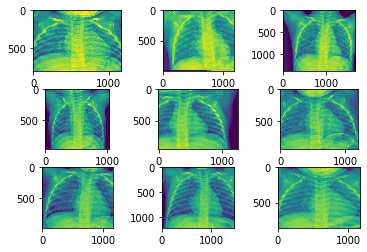

In [39]:
fig, axs = plt.subplots(3,3)
plt.subplots_adjust(wspace=0.3, hspace=0.3)
for i, filen in enumerate(normal_df.sample(9, random_state=1).filename):
    file = train_dir + filen
    img = mpimg.imread(file)
    axs[int(i/3),i%3].imshow(img)
plt.savefig('normal.png')
plt.show()

#### Viral

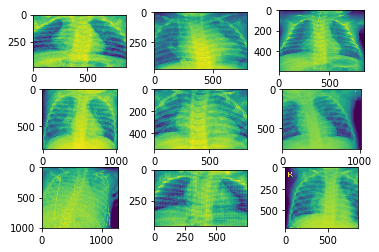

In [40]:
fig, axs = plt.subplots(3,3)
plt.subplots_adjust(wspace=0.3, hspace=0.3)
for i, filen in enumerate(viral_df.sample(9, random_state=1).filename):
    file = train_dir + filen
    img = mpimg.imread(file)
    axs[int(i/3),i%3].imshow(img)
plt.savefig('viral.png')
plt.show()

#### Bacterial

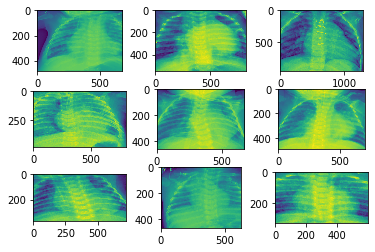

In [41]:
fig, axs = plt.subplots(3,3)
plt.subplots_adjust(wspace=0.3, hspace=0.3)
for i, filen in enumerate(bacterial_df.sample(9, random_state=1).filename):
    file = train_dir + filen
    img = mpimg.imread(file)
    axs[int(i/3),i%3].imshow(img)
    
plt.savefig('bacterial.png')
plt.show()

#### Covid

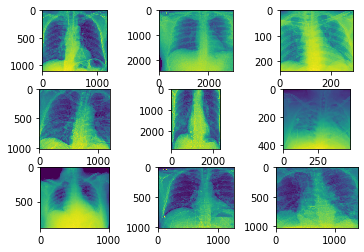

In [42]:
fig, axs = plt.subplots(3,3)
plt.subplots_adjust(wspace=0.3, hspace=0.3)
for i, filen in enumerate(covid_df.sample(9, random_state=1).filename):
    file = train_dir + filen
    img = mpimg.imread(file)
    axs[int(i/3),i%3].imshow(img)
plt.savefig('covid.png')
plt.show()

There seems to be a noticeable difference in the images between "non-covid" ("normal", "viral", "bacterial") images and "covid" images. Specifically, the "non-covid" images seem to have images with clearer rib cages compared to "covid" images. In addition, the covid images seem to have "darker" lungs, which may also affect the classification. Since the classification of chest x-rays are supposed to be difficult for nonexperts, the obvious differences that can be observed to the human eye may be a sign that the process of data collection differed between "non-covid" and "covid" images. Therefore, to build a robust classification model from these images, there is a need to make the model learn from the less obvious characteristics inside of the data. One approach to this is to randomly change the brightness intensity of the data, so that the "darker" lungs of the "covid" images get brighter, and the "brighter" lungs of the "non-covid" images get darker. Another approach is to add random Gaussian noise to the image so that the clearness of the rib cages may have less chance of affecting the classification, but to prevent too much increase in the complexity in the representation of the data (since there are other data augmentations needed which will be explained in the next paragraph), we will not add random noise to the data here.

Now focusing on all of the images at the same time, there seems to be images where the location of the lung is shifted towards the left or right, images that have tilted targets, images that seem to be stretched to the side, and images in which the lungs are not fitting into the image. To make the classification model less sensitive to these characteristics of the images that are not related to the actual label, the data should be randomly flipped horizontally, randomly rotated, and focused on random parts of the image. 

Summarizing the above points, the training data will be augmented randomly with the following techniques:
- Changing the brightness intensity
- Flipping the image horizontally
- Rotating the image by a small degree
- Focusing on a part of the image

Finally, the size of the images seem to differ between labels. The size of "normal" images appear to be formatted more consistently compared to the other 3 types of images. Especially, the size of "covid" images seem to be very inconsistent, since in this sample there are images that are about the size of 250x250 ranging to 2000x2000. Let's take a closer look at the distribution in the size of images.

In [43]:
normal_img_dims = []
for i, filen in enumerate(normal_df.filename):
    file = train_dir + filen
    img = mpimg.imread(file)
    normal_img_dims.append(list(img.shape))
normal_img_dims = np.array(normal_img_dims)

In [44]:
viral_img_dims = []
for i, filen in enumerate(viral_df.filename):
    file = train_dir + filen
    img = mpimg.imread(file)
    viral_img_dims.append(list(img.shape))
viral_img_dims = np.array(viral_img_dims)

In [45]:
bacterial_img_dims = []
for i, filen in enumerate(bacterial_df.filename):
    file = train_dir + filen
    img = mpimg.imread(file)
    bacterial_img_dims.append(list(img.shape))
bacterial_img_dims = np.array(bacterial_img_dims)

In [46]:
covid_img_dims = []
for i, filen in enumerate(covid_df.filename):
    file = train_dir + filen
    img = mpimg.imread(file)
    covid_img_dims.append(list(img.shape))
covid_img_dims = np.array(covid_img_dims)

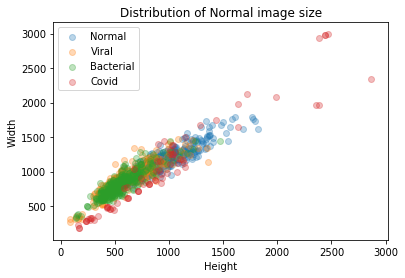

In [47]:
# Distribution of image size
plt.scatter(normal_img_dims[:,0], normal_img_dims[:,1], alpha=0.3)
plt.scatter(viral_img_dims[:,0], viral_img_dims[:,1], alpha=0.3)
plt.scatter(bacterial_img_dims[:,0], bacterial_img_dims[:,1], alpha=0.3)
plt.scatter(covid_img_dims[:,0], covid_img_dims[:,1], alpha=0.3)
plt.title('Distribution of Normal image size')
plt.xlabel('Height')
plt.ylabel('Width')
plt.legend(['Normal', 'Viral', 'Bacterial', 'Covid'])
plt.savefig('distribution.png')
plt.show()

The images seem to have different sizes across all labels. Although the images are in different sizes, the height and width of the images seem to be close to each other, meaning that most of the images are "square-shaped". Also, as previously noticed, the size of "covid" images seem to be unstable. The actual values of the sizes are summarized below.

In [17]:
# Statistics of image size
print('[Height, Width]')
print('')
print('Normal')
print('Max: ' + str(np.amax(normal_img_dims, axis=0)))
print('Min: ' + str(np.amin(normal_img_dims, axis=0)))
print('Average: ' + str(np.mean(normal_img_dims, axis=0)))
print('Median: ' + str(np.median(normal_img_dims, axis=0)))
print('Variance: ' + str(np.var(normal_img_dims, axis=0)))
print('')
print('Viral')
print('Max: ' + str(np.amax(viral_img_dims, axis=0)))
print('Min: ' + str(np.amin(viral_img_dims, axis=0)))
print('Average: ' + str(np.mean(viral_img_dims, axis=0)))
print('Median: ' + str(np.median(viral_img_dims, axis=0)))
print('Variance: ' + str(np.var(viral_img_dims, axis=0)))
print('')
print('Bacterial')
print('Max: ' + str(np.amax(bacterial_img_dims, axis=0)))
print('Min: ' + str(np.amin(bacterial_img_dims, axis=0)))
print('Average: ' + str(np.mean(bacterial_img_dims, axis=0)))
print('Median: ' + str(np.median(bacterial_img_dims, axis=0)))
print('Variance: ' + str(np.var(bacterial_img_dims, axis=0)))
print('')
print('Covid')
print('Max: ' + str(np.amax(covid_img_dims, axis=0)))
print('Min: ' + str(np.amin(covid_img_dims, axis=0)))
print('Average: ' + str(np.mean(covid_img_dims, axis=0)))
print('Median: ' + str(np.median(covid_img_dims, axis=0)))
print('Variance: ' + str(np.var(covid_img_dims, axis=0)))

[Height, Width]

Normal
Max: [1820 1794]
Min: [522 694]
Average: [ 977.29428571 1174.18285714]
Median: [ 938.  1164.5]
Variance: [51950.6591102  39666.26942041]

Viral
Max: [1360 1465]
Min: [ 88 268]
Average: [609.45428571 887.75714286]
Median: [573.5 896. ]
Variance: [41416.88219592 41967.40102041]

Bacterial
Max: [1472 1450]
Min: [140 323]
Average: [563.15714286 826.25142857]
Median: [537. 806.]
Variance: [30713.20673469 34954.82821224]

Covid
Max: [2866 2996]
Min: [165 178]
Average: [ 938.94805195 1044.37662338]
Median: [883. 909.]
Variance: [379676.594704   460686.49451847]


The size of "non-covid" images seem to be more balanced compared to "covid" images since they have smaller variance in the sizes of the images. 

The difference in the size of images need to be carefully examined because models generally require an input with the same dimensions. In this problem setting, since the inputs have different sizes, we need to think of a way to align the images into the same size. From the data size distribution, two vague clusters which were images which the size close to (250, 250), and images with size (500, 500) or bigger. Since the majority of the images were bigger than (500,500), and it could be hypothesized that the characteristics of the COVID-19 can be captured more efficiently with high resolutions, I decided to resize all the images to (500,500).

Next, we look at the number of samples per label.

### Number of Samples per Label

In [18]:
train_df.groupby('label').count()

,filename
label,
bacterial,350
covid,77
normal,350
viral,350


There is an unbalance in between the number of "covid" images compared to the other types of images. To be sure that during the training, the model will not be biased towards "non-covid" images, some effort has to be made. The efforts I will make are to incorporate data augmentation with the techniques stated above, and also use a loss function in the model which weights the classification accuracy depending on the number of training samples per label, where the smaller the sample size is for a label, the bigger the weight is. This is also called the weighted classification accuracy, which is exactly the evaluation metric given in Kaggle.  

Now that we have explored the data thoroughly, we will move on to defining and implementing the classifier model.

# 2. Model Defining, Implementation, and Results

For image classification tasks, classical machine learning models such as Support Vector Machines have been used in the past, but ever since the rise of Convolutional Neural Network (CNN) models, classical machine learning models are rarely used. CNNs and its variants have been used extensively and have been producing state-of-the-art results. Such deep learning models require a vast amount of training data, but in this competition, there is a limited training data size of 1127. To overcome the lack of training data, I will choose to apply transfer learning to this classification task. Specifically, transfer learning is to take the structure and weights from a model that has been trained in another similar task, and use them for the weights in the model that will be used for the target task. Not only does transfer learning reduce the amount of training data needed, but it also provides good generalization, and saves training time. Here in this problem setting, I will transfer learn from a CNN that was trained on images for a classification task. Specifically, since Keras provides pretrained CNNs from the ImageNet dataset, as a starting point I will use one of those pretrained CNNs.

Before moving on to the implementation, I will share a disadvantage of using deep learning models like CNNs regarding interpretability. Deep learning models are known to be uninterpretable, meaning that the reasoning behind the decisions cannot be understood easily. Therefore, deep learning models may not have value when the objective is to understand the reasoning behind decisions. Classical classification models such as multiclass random forests (RFs) are known to be capable of showing which features were important to the classification decision, but in image classification, RFs do not achieve great results due to the complexity of the data (images can have shifts, different color intensities, etc.).

Now, I will describe the CNN structure in detail.

The pretrained CNN model I use is the ResNet50, since it was a popular model to be used for transfer learning. The ResNet is the model that won the ImageNet challenge (Image Classification challenge) in 2015, and the strengths of this model is that the layers are much deeper than other models, allowing the model to learn more complex concepts. Prior to the ResNet, deep learning models with many layers had trouble learning due to the gradient vanishing problem. But after the ResNet introduced the "skip connection" concept, which was to connect an output of a layer into a layer that was a number of layers ahead so that the gradients can flow through, models with deeper layers were possible to be trained. The 50 in ResNet50 stands for the number of layers in the model, and there are other ResNet models with more layers, but here for simplicity the ResNet50 was chosen.

Using the Keras library, I imported the ResNet50 model with image input size (500, 500) which was pretrained on the ImageNet dataset. To make use of this pretrained ResNet50 for the chest x-ray classification task, some tweaks needed to bew made. Since the ResNet50 model was originally trained on colored RGB images, the color dimension of grayscale chest x-rays had to be changed from 1 dimension to 3 dimensions. To achieve this, an additional convolutional layer was used before the input so that the input image became a stack of 3 matrices to represent the 3 dimensions of color. Another change that needed to be made was the output layer of the ResNet50, since the number of classes to classify into were different in the ImageNet classification task. Therefore, I removed the last dense (full-connected) layer of the ResNet50, and replaced it with a dense layer that had 4 output nodes corresponding to the number of unique labels. Now let's move on to the actual training of this model. 

This ResNet50 pretrained model was trained on the images with augmentation applied according to the previous stated techniques. The data was splitted into train and validation data at the ratio of 4:1. While keeping the weights of the ResNet50 constant, the pretrained model was trained, which converged in 6 epochs. The results were horrible, with a validation accuracy of less than 20%, which meant that this model was not capturing the concept of the images correctly. With this fact, many directions for improvement came up:
- Model Structure
    - Stop using transfer learning
    - Change the pretrained model architecture to a different model such as DenseNets and Xceptions
    - Change the architecture of ResNet50
- Model Configuration
    - Allow the update of weights
    - Change optimizers (Used the popular optimizer Adam)
    - Change hyperparameters (Used default)
    - Change batch size (Used the popular batch size)
- Data
    - Change the data augmentation methods
    - Change the data used for pretraining
    - Change the size of the data 
    
Out of these choices, I decided to focus on changes that I thought were likely to improve results drastically, which were mostly Model Structure and Data related changes. These were (i) Stop transfer learning, (ii) Changing the pretrained model architecture to a different model, (iii) Changing the data used for pretraining, (iv) Allow the update of weights, (v) Changing the architecture of ResNet50, which I will describe next.

### (i) Stop transfer learning
Although earlier I stated the strengths of transfer learning, with the result of the first transfer learning model, I had a suspicion that the dataset in this task was not compatible for transfer learning. Therefore, next I implemented a non-transfer learning CNN model. To utilize the limited data effectively, I applied data augmentation, as well as a technique called progressive resizing. Progressive resizing is a technique where the model is trained from input data that was resized into the minimum data size, then progressively layers with bigger input sizes are added on top of the previous input layer after each training. This technique is thought to be able to capture the entire image structure better, since each layer is trained to focus on different granularities. The initial model was a simple CNN model with 3 convolutional and pooling layers, with dense layers that outputted the target class. Batch normalization was also used between layers, as it was known to help with the generalization of the model as well as make training efficient. As a starter, the input size of the model was (88,88), since 88 was the smallest dimension that existed in the dataset. The following layers that were added had an input size of (176,176) and (528, 528), since each additional layer had to be a multiple of the first input size.

The highest validation accuracy achieved by this model was 0.6477, and was able to score 0.68954 against the test set. As a note, a similar model was experimented without progressive resizing, which scored 0.63398 against the test set. Using a non-transfer learning CNN model with progressive resizing seemed to improve the accuracy of the model, but it was still far from reaching the Full Credit Benchmark score 0.80065. There may be ways of improving the non-transfer learning CNN model, but as I felt that there needed to be another drastic change that had to be made on the model, I shifted back to transfer learning.

### (ii) Changing the pretrained model architecture to a different model
Luckily, Keras provides ImageNet pretrained models with different architectures. Therefore, it was very straightforward to experiment with pretrained models with different architectures. The models that were trained had the same architecture as the ResNet50 pretrained model, except that the ResNet50 part of the model was swapped with the different architectures. The different pretrained models that were applied were MobileNet, Xception, DenseNet121, and NASNetLarge. Each architecture has an advantage of its own, and the hypothesis was that there would be a model that will be compatible with the chest x-ray dataset. Stating results shortly, none of these models were able to increase the validation accuracy drastically. Therefore, next I focused on changing the data used for pretraining, which was to use a model that was pretrained on another chest x-ray dataset.

### (iii) Changing the data used for pretraining
The Stanford ML group provides a chest x-ray dataset called ChestX-ray14, which was each labeled with one of 14 types of diseases. Since this data is the same type of data as the chest x-ray data in this challenge, a model pretrained on the ChestX-ray14 data was thought to be more compatible with the given chest x-ray data. A github user called brucechou1983 (https://github.com/brucechou1983/CheXNet-Keras) provided weights of DenseNet121 that were pretrained with the ChestX-ray14 data, I applied this model for the transfer learning setting. Since the provided weights were only compatible for images of size (224, 224), the input size differed from the previous transfer learning setting experimentes. With high expectation towards this model, when the model provided weaker results than expected, I attempted to change the structure of the network such as adding additional convolutional and pooling layers. But I was not able to find an architecture where results drastically improved since the highest validation accuracy I was able to achieve was a little above 50%. I am still not completely certain of why this pretrained model did not aid in providing great results, but an explanation that could be given is that given chest x-ray data was "dirtier" compared to the consistently sized and clean image data used to train the pretrained model. After all the struggle, we now return to the ResNet50 model.

### (iv) Allowing the update of weights of ResNet50
Earlier, the ResNet50 was trained while keeping all of the weights of the ResNet50 part of the model still. Initially this was done because the number of data samples were small, and there was risk of overfitting if those weights were also able to be trained. But since there still may be a possibility that the model would not overfit, training was done with unfrozen weights. As expected though, the validation accuracy was very low, with a validation accuracy of about 6%. On the other hand, the training accuracy was slightly higher compared to the previous experiments. From these results, it became clear that unfrozen weights could lead to overfitting, but has the freedom to help fit to the data. Thus, balancing the ratio of "frozen" weights and "unfrozen" weights may allow the model to be able to make use of the generalization strengths of pretraining models as well as the representation ability of neural networks. The next idea takes this into account.

### (v) Changing the architecture of ResNet50
From (iv) we learned that balancing the "frozen" and "unfrozen" weights properly could lead to a robust model that could still learn the data. The intuitive way of achieving this is through allowing the weights closer to the output layer (lower layers) to be "unfrozen", while keeping the weights closer to the input layer (higher layers) "frozen". Still, since unfreezing the layers close to the output layers, then retraining the model may consume a lot of time on a laptop, especially since the ResNet50 architecture contains a large number of weights, the approach we take is to replace the lower layers with only a few convolutional and pooling layers. The idea is that this reduces the number of parameters that need to be trained, while still being able to utilize the feature extracting strengths of the pretrained model. An additional tweak added to the new model was a convolutional and pooling layer added in front of the input layer, which was thought to change the new input data to be more compatible with the pretrained model. Using this new model, the unweighted validation accuracy was 0.747, while the weighted validation accuracy was 0.809. The submission to Kaggle gave a weighted accuracy of 0.81045, passing the full credit benchmark.

Taking a look at the confusion matrix (labels 0, 1, 2, 3 represent bacterial, covid, normal, and viral respectively), there seems to be no labels that are strongly being preferred over the other during predictions, which is a strength of the model. As a weakness of the model though, it seems to have some trouble distinguishing bacterial and viral pneumonia. Therefore, a direction of future work is to focus on those two types of pneumonia, for example by making a separate classifier for only those two types of pneumonia, and incorporating the decision of that classifier into the final decision. This type of work is very important in clinical settings, especially since the way of treating viral and bacterial pneumonia differ between each other. If the classification was inaccurate, then the patient may be given the wrong medication, which will decrease the chance of curing.

Put confusion matrix here

Regarding the interpretability of this model, it is difficult to understand which features the classifier used to distinguish between different classes. But one thing that worries me is that the viral and bacterial images look the most similar compared to other labels to the raw eye (images seem stretched out more), and those images have lower accuracy compared to the other labels. Therefore, the classifier may have learned obvious characteristics which resulted from the way the images were taken, rather than the characteristics of the disease itself. If this was the case, this classifier should not be used in the real life setting, since the input images may be taken differently, and incorrect decisions can be made.

# 3. Issues and Conclusion

The biggest issues I encountered during this project was defining a structure that was able to generalize to the chest x-ray images well. There were infinitely many ways the model could be structured, and it was very time-consuming to try models out, then making fixes, and repeating. Especially, when I used the pretrained ChexNet weights, in the beginning I strongly believed that the model will work well without many changes. After making different types of fixes to the model (with different combinations of fixes as well), such as changing data augmentation, model structure, freezing and unfreezing weights, adding additional layers, removing layers, there was no model that I was able to define which increased the validation accuracy to the desired level. This experience helped me learn that defining the architecture of deep learning models was close to sorcery, which is another reason why interpreting the reasoning behind deep learning model decisions were difficult. Next time, if the amount of time I had for the project was the same, I would start by using a transfer learning model, and repeat the process of finding an architecture that was compatible to the problem setting. If I had more time, I would look into more papers of the newest research being done regarding the problem setting, and devise a more solid strategy. 

This project was definitely a great experience to learn about the complexities regarding image classification using deep learning. And I also believe it was a valuable opportunity to grasp how machine learning is of value to the society.

# 4. Model Implementation Code

### Libraries for Model

In [19]:
import keras
from keras_preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Flatten, Dense, Dropout, GlobalAveragePooling2D, Conv2D, Activation, MaxPooling2D, ZeroPadding2D, BatchNormalization, GaussianNoise
from keras.optimizers import Adam, SGD, Nadam
from keras.models import Model
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.applications.resnet50 import ResNet50
from keras.applications.mobilenet import MobileNet
from keras.applications.xception import Xception
from keras.applications.densenet import DenseNet121
from keras.applications.nasnet import NASNetLarge
from keras.models import load_model
from keras.models import model_from_json
from keras import metrics

/Users/nishimura_yuki/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/Users/nishimura_yuki/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


#### Setting Up ImageDataGenerator to Augment Images and Split Train and Validation

In [20]:
train_data_generator = ImageDataGenerator(
    rotation_range = 30,
    width_shift_range = 0.3,
    height_shift_range = 0.3,
    brightness_range = [0.8, 1.2],
    zoom_range = 0.2,
    horizontal_flip = True,
    rescale = 1/255,
    validation_split=0.2
)

test_data_generator = ImageDataGenerator(
    rescale = 1/255,
)

## MODEL1: Non-Pretrained Model with Progressive Resizing

Progressive 1st Model Training

In [ ]:
batch_size = 32
image_reshape_size = [88, 88]

train_generator = train_data_generator.flow_from_dataframe(
    dataframe = train_df,
    directory = train_dir,
    x_col = 'filename',
    y_col = 'label',
    target_size = tuple(image_reshape_size),
    batch_size = batch_size,
    color_mode= 'grayscale',
    class_mode = 'categorical',
    subset='training',
    seed = 1
)

validation_generator = train_data_generator.flow_from_dataframe(
    dataframe = train_df,
    directory = train_dir,
    x_col = 'filename',
    y_col = 'label',
    target_size = tuple(image_reshape_size),
    batch_size = batch_size,
    color_mode= 'grayscale',
    class_mode = 'categorical',
    subset='validation',
    seed = 1
)

input_shape = image_reshape_size.copy()
input_shape.append(1)
input_shape = tuple(input_shape)

In [ ]:
model1 = Sequential()
model1.add(Conv2D(32, (3, 3), input_shape=input_shape, padding='same'))
model1.add(BatchNormalization())
model1.add(Activation('relu'))
model1.add(MaxPooling2D(pool_size=(2, 2)))
model1.add(Conv2D(32, (3, 3), padding='same'))
model1.add(BatchNormalization())
model1.add(Activation('relu'))
model1.add(MaxPooling2D(pool_size=(2, 2)))
model1.add(Conv2D(32, (3, 3), padding='same'))
model1.add(BatchNormalization())
model1.add(Activation('relu'))
model1.add(MaxPooling2D(pool_size=(2, 2)))
model1.add(Flatten())
model1.add(Dense(128))
model1.add(Activation('relu'))
model1.add(Dropout(0.2))
model1.add(Dense(4))
model1.add(Activation('softmax'))

In [ ]:
model1.compile(
    optimizer=Adam(),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
class_weights = {train_generator.class_indices[label]: len(train_df)/count for label, count in zip(train_df.groupby('label').count().index, train_df.groupby('label').count().filename.values)}

In [ ]:
model1.fit_generator(
    train_generator,
    steps_per_epoch=len(train_generator.filenames) // batch_size,
    epochs=20,
    validation_data=validation_generator,
    validation_steps=len(validation_generator.filenames) // batch_size,
    class_weight=class_weights,
    callbacks=[
        EarlyStopping(patience=3, restore_best_weights=True),
        ReduceLROnPlateau(patience=2)
    ]
)

In [ ]:
model1.save('progressive_model1.h5')

Progressing 2nd Model Training

In [ ]:
model1 = load_model('progressive_model1.h5')

In [ ]:
batch_size = 32
image_reshape_size = [176, 176]

train_generator = train_data_generator.flow_from_dataframe(
    dataframe = train_df,
    directory = train_dir,
    x_col = 'filename',
    y_col = 'label',
    target_size = tuple(image_reshape_size),
    batch_size = batch_size,
    color_mode= 'grayscale',
    class_mode = 'categorical',
    subset='training',
    seed = 1
)

validation_generator = train_data_generator.flow_from_dataframe(
    dataframe = train_df,
    directory = train_dir,
    x_col = 'filename',
    y_col = 'label',
    target_size = tuple(image_reshape_size),
    batch_size = batch_size,
    color_mode= 'grayscale',
    class_mode = 'categorical',
    subset='validation',
    seed = 1
)

input_shape = image_reshape_size.copy()
input_shape.append(1)
input_shape = tuple(input_shape)

In [ ]:
model2 = Sequential()
model2.add(Conv2D(32, (3, 3), input_shape=input_shape, padding='same'))
model2.add(BatchNormalization())
model2.add(Activation('relu'))
model2.add(MaxPooling2D(pool_size=(2, 2)))
model2.add(Conv2D(32, (3, 3), padding='same'))
model2.add(BatchNormalization())
model2.add(Activation('relu'))
model2.add(MaxPooling2D(pool_size=(2, 2)))

for layer in model1.layers[4:]:
    model2.add(layer)

In [ ]:
model2.compile(
    optimizer=Adam(),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
class_weights = {train_generator.class_indices[label]: len(train_df)/count for label, count in zip(train_df.groupby('label').count().index, train_df.groupby('label').count().filename.values)}

In [ ]:
model2.fit_generator(
    train_generator,
    steps_per_epoch=len(train_generator.filenames) // batch_size,
    epochs=20,
    validation_data=validation_generator,
    validation_steps=len(validation_generator.filenames) // batch_size,
    class_weight=class_weights,
    callbacks=[
        EarlyStopping(patience=3, restore_best_weights=True),
        ReduceLROnPlateau(patience=2)
    ]
)

In [ ]:
model2.save('progressive_model2.h5')

Progressing Final Model Training

In [ ]:
batch_size = 32
image_reshape_size = [528, 528]

train_generator = train_data_generator.flow_from_dataframe(
    dataframe = train_df,
    directory = train_dir,
    x_col = 'filename',
    y_col = 'label',
    target_size = tuple(image_reshape_size),
    batch_size = batch_size,
    color_mode= 'grayscale',
    class_mode = 'categorical',
    subset='training',
    seed = 1
)

validation_generator = train_data_generator.flow_from_dataframe(
    dataframe = train_df,
    directory = train_dir,
    x_col = 'filename',
    y_col = 'label',
    target_size = tuple(image_reshape_size),
    batch_size = batch_size,
    color_mode= 'grayscale',
    class_mode = 'categorical',
    subset='validation',
    seed = 1
)

input_shape = image_reshape_size.copy()
input_shape.append(1)
input_shape = tuple(input_shape)

In [ ]:
model2.summary()

In [ ]:
model3 = Sequential()
model3.add(Conv2D(32, (3, 3), input_shape=input_shape, padding='same'))
model3.add(BatchNormalization())
model3.add(Activation('relu'))
model3.add(MaxPooling2D(pool_size=(3, 3)))
model3.add(Conv2D(32, (3, 3), padding='same'))
model3.add(BatchNormalization())
model3.add(Activation('relu'))
model3.add(MaxPooling2D(pool_size=(2, 2)))

for layer in model2.layers[4:]:
    model3.add(layer)

In [ ]:
model3.compile(
    optimizer=Adam(),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
class_weights = {train_generator.class_indices[label]: len(train_df)/count for label, count in zip(train_df.groupby('label').count().index, train_df.groupby('label').count().filename.values)}

In [ ]:
model3.fit_generator(
    train_generator,
    steps_per_epoch=len(train_generator.filenames) // batch_size,
    epochs=20,
    validation_data=validation_generator,
    validation_steps=len(validation_generator.filenames) // batch_size,
    class_weight=class_weights,
    callbacks=[
        EarlyStopping(patience=4, restore_best_weights=True),
        ReduceLROnPlateau(patience=2)
    ]
)

In [ ]:
model3.save('progressive_model3.h5')

In [ ]:
test_generator= test_data_generator.flow_from_dataframe(
    dataframe = test_df,
    directory= test_dir,
    x_col="filename",
    color_mode="grayscale",
    batch_size= batch_size,
    target_size = tuple(image_reshape_size),
    class_mode=None,
    shuffle=False
)
test_generator.reset()

test_filenames = test_generator.filenames
test_size = len(test_filenames)

predict = model3.predict_generator(test_generator, steps = test_size/batch_size)

In [ ]:
predicted_classes = np.argmax(predict,axis=1)
labels = (train_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())
predictions = [labels[k] for k in predicted_classes]
ids = np.arange(test_size)
results=pd.DataFrame({"Id":ids,
                      "label":predictions})
results.to_csv('submission2.csv', index=None)
pd.read_csv('submission2.csv')

## MODEL2: ResNet50 Transfer Learning

In [21]:
batch_size = 32
image_reshape_size = [500, 500]

train_generator = train_data_generator.flow_from_dataframe(
    dataframe = train_df,
    directory = train_dir,
    x_col = 'filename',
    y_col = 'label',
    target_size = tuple(image_reshape_size),
    batch_size = batch_size,
    color_mode = 'grayscale',
    class_mode = 'categorical',
    subset='training',
    seed = 1
)

validation_generator = train_data_generator.flow_from_dataframe(
    dataframe = train_df,
    directory = train_dir,
    x_col = 'filename',
    y_col = 'label',
    target_size = tuple(image_reshape_size),
    batch_size = batch_size,
    color_mode = 'grayscale',
    class_mode = 'categorical',
    subset='validation',
    seed = 1
)

resnet_input_shape = image_reshape_size.copy()
resnet_input_shape.append(3)
resnet_input_shape = tuple(resnet_input_shape)

model_input_shape = image_reshape_size.copy()
model_input_shape.append(1)
model_input_shape = tuple(model_input_shape)

Found 902 validated image filenames belonging to 4 classes.
Found 225 validated image filenames belonging to 4 classes.


In [44]:
# Imagenet Pretrained ResNet50
resnet = ResNet50(
    include_top = False,
    weights = 'imagenet',
    input_shape=resnet_input_shape
)

/Users/nishimura_yuki/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


In [45]:
# Check layers of ResNet50
resnet.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 500, 500, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 506, 506, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 250, 250, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 250, 250, 64) 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

In [46]:
resnet_top = Model(resnet.input, resnet.layers[-len(resnet.layers[142:])].output)
resnet_top.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 500, 500, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 506, 506, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 250, 250, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 250, 250, 64) 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

In [49]:
res_transfer_model1 = Sequential()
res_transfer_model1.add(Conv2D(3, (3, 3), padding='same', input_shape = model_input_shape))
res_transfer_model1.add(resnet_top)
res_transfer_model1.add(Conv2D(32, (3, 3), padding='same'))
res_transfer_model1.add(BatchNormalization())
res_transfer_model1.add(Activation('relu'))
res_transfer_model1.add(Conv2D(32, (3, 3), padding='same'))
res_transfer_model1.add(BatchNormalization())
res_transfer_model1.add(Activation('relu'))
res_transfer_model1.add(MaxPooling2D(pool_size=(2, 2)))
res_transfer_model1.add(Conv2D(32, (3, 3), padding='same'))
res_transfer_model1.add(BatchNormalization())
res_transfer_model1.add(Activation('relu'))
res_transfer_model1.add(Conv2D(32, (3, 3), padding='same'))
res_transfer_model1.add(BatchNormalization())
res_transfer_model1.add(Activation('relu'))
res_transfer_model1.add(MaxPooling2D(pool_size=(2, 2)))
res_transfer_model1.add(Conv2D(32, (3, 3), padding='same'))
res_transfer_model1.add(BatchNormalization())
res_transfer_model1.add(Activation('relu'))
res_transfer_model1.add(Conv2D(32, (3, 3), padding='same'))
res_transfer_model1.add(BatchNormalization())
res_transfer_model1.add(Activation('relu'))
res_transfer_model1.add(MaxPooling2D(pool_size=(2, 2)))
res_transfer_model1.add(Flatten())
res_transfer_model1.add(Dense(256))
res_transfer_model1.add(Activation('relu'))
res_transfer_model1.add(Dropout(0.2))
res_transfer_model1.add(Dense(4))
res_transfer_model1.add(Activation('softmax'))

In [50]:
for resnet_layer in res_transfer_model1.layers[1].layers:
    resnet_layer.trainable = False

In [51]:
res_transfer_model1.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 500, 500, 3)       30        
_________________________________________________________________
model_2 (Model)              (None, 32, 32, 1024)      8589184   
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 32, 32, 32)        294944    
_________________________________________________________________
batch_normalization_8 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
activation_116 (Activation)  (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 32, 32, 32)        9248      
_________________________________________________________________
batch_normalization_9 (Batch (None, 32, 32, 32)        128       
__________

In [52]:
res_transfer_model1.compile(
    optimizer=Adam(),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [53]:
class_weights = {train_generator.class_indices[label]: len(train_df)/count for label, count in zip(train_df.groupby('label').count().index, train_df.groupby('label').count().filename.values)}

In [54]:
res_transfer_model1.fit_generator(
    train_generator,
    steps_per_epoch=len(train_generator.filenames) // batch_size,
    epochs=20,
    validation_data=validation_generator,
    validation_steps=len(validation_generator.filenames) // batch_size,
    class_weight=class_weights,
    callbacks=[
        EarlyStopping(patience=3, restore_best_weights=True),
        ReduceLROnPlateau(patience=2)
    ]
)

Epoch 1/20
28/28 [==============================] - 6340s 226s/step - loss: 6.8400 - acc: 0.3222 - val_loss: 1.4938 - val_acc: 0.4286
Epoch 2/20
28/28 [==============================] - 6272s 224s/step - loss: 3.9753 - acc: 0.5201 - val_loss: 1.2537 - val_acc: 0.5026
Epoch 3/20
28/28 [==============================] - 5421s 194s/step - loss: 2.6420 - acc: 0.6380 - val_loss: 0.8109 - val_acc: 0.5596
Epoch 4/20
28/28 [==============================] - 5107s 182s/step - loss: 2.5305 - acc: 0.6464 - val_loss: 0.8809 - val_acc: 0.5544
Epoch 5/20
28/28 [==============================] - 5346s 191s/step - loss: 2.5321 - acc: 0.6272 - val_loss: 0.8945 - val_acc: 0.6269
Epoch 6/20
28/28 [==============================] - 5818s 208s/step - loss: 2.1238 - acc: 0.6531 - val_loss: 0.7637 - val_acc: 0.6373
Epoch 7/20
28/28 [==============================] - 5978s 213s/step - loss: 2.3009 - acc: 0.6517 - val_loss: 0.5758 - val_acc: 0.6580
Epoch 8/20
28/28 [==============================] - 6209s 222s

In [ ]:
#res_transfer_model1.save('resnet_transfer_model1.h5')

In [ ]:
test_generator= test_data_generator.flow_from_dataframe(
    dataframe = test_df,
    directory= test_dir,
    x_col="filename",
    color_mode="grayscale",
    batch_size= batch_size,
    target_size = tuple(image_reshape_size),
    class_mode=None,
    shuffle=False
)
test_generator.reset()

test_filenames = test_generator.filenames
test_size = len(test_filenames)

predict = res_transfer_model1.predict_generator(test_generator, steps = test_size/batch_size)

In [ ]:
predicted_classes = np.argmax(predict,axis=1)
labels = (train_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())
predictions = [labels[k] for k in predicted_classes]
ids = np.arange(test_size)
results=pd.DataFrame({"Id":ids,
                      "label":predictions})
results.to_csv('submission3.csv', index=None)
pd.read_csv('submission3.csv')

In [ ]:
res_transfer_model1 = load_model('resnet_transfer_model1.h5')

### MODEL3: MobileNet Transfer Learning

In [135]:
batch_size = 32
image_reshape_size = [224, 224]

train_generator = train_data_generator.flow_from_dataframe(
    dataframe = train_df,
    directory = train_dir,
    x_col = 'filename',
    y_col = 'label',
    target_size = tuple(image_reshape_size),
    batch_size = batch_size,
    # Converted to have 3 channels
    #color_mode = 'rgb',
    color_mode = 'grayscale',
    class_mode = 'categorical',
    subset='training',
    seed = 1
)

validation_generator = train_data_generator.flow_from_dataframe(
    dataframe = train_df,
    directory = train_dir,
    x_col = 'filename',
    y_col = 'label',
    target_size = tuple(image_reshape_size),
    batch_size = batch_size,
    # Converted to have 3 channels
    #color_mode = 'rgb',
    color_mode = 'grayscale',
    class_mode = 'categorical',
    subset='validation',
    seed = 1
)

mobilenet_input_shape = image_reshape_size.copy()
mobilenet_input_shape.append(3)
mobilenet_input_shape = tuple(mobilenet_input_shape)

model_input_shape = image_reshape_size.copy()
model_input_shape.append(1)
model_input_shape = tuple(model_input_shape)

Found 902 validated image filenames belonging to 4 classes.
Found 225 validated image filenames belonging to 4 classes.


In [152]:
# Imagenet Pretrained MobileNet
mobilenet = MobileNet(
    include_top = False,
    weights = 'imagenet',
    input_shape=xception_input_shape
)

In [153]:
# Check layers of MobileNet
mobilenet.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        (None, 224, 224, 3)       0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 225, 225, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)      128       
__________

In [194]:
mobilenet.layers[-5]

In [186]:
mobilenet_top = Model(mobilenet.input, mobilenet.layers[-20].output)

AttributeError: Layer mobilenet_1.00_224 has multiple inbound nodes, hence the notion of "layer input" is ill-defined. Use `get_input_at(node_index)` instead.

In [195]:
mobilenet_transfer_model1 = Sequential()
mobilenet_transfer_model1.add(Conv2D(3, (3, 3), padding='same', input_shape = model_input_shape))
mobilenet_transfer_model1.add(BatchNormalization())
mobilenet_transfer_model1.add(Activation('relu'))
mobilenet_transfer_model1.add(MaxPooling2D(pool_size=(2, 2)))
mobilenet_transfer_model1.add(mobilenet)
#mobilenet_transfer_model1.add(mobilenet_top)
#mobilenet_transfer_model1.add(Conv2D(32, (3, 3), padding='same'))
#mobilenet_transfer_model1.add(BatchNormalization())
#mobilenet_transfer_model1.add(Activation('relu'))
#mobilenet_transfer_model1.add(MaxPooling2D(pool_size=(2, 2)))
#mobilenet_transfer_model1.add(Conv2D(32, (3, 3), padding='same'))
#mobilenet_transfer_model1.add(BatchNormalization())
#mobilenet_transfer_model1.add(Activation('relu'))
mobilenet_transfer_model1.add(Flatten())
mobilenet_transfer_model1.add(Dense(256))
mobilenet_transfer_model1.add(Activation('relu'))
mobilenet_transfer_model1.add(Dropout(0.2))
mobilenet_transfer_model1.add(Dense(4))
mobilenet_transfer_model1.add(Activation('softmax'))

In [196]:
for mobilenet_layer in mobilenet_transfer_model1.layers[4].layers[:-6]:
    mobilenet_layer.trainable = False

In [197]:
mobilenet_transfer_model1.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_100 (Conv2D)          (None, 224, 224, 3)       30        
_________________________________________________________________
batch_normalization_100 (Bat (None, 224, 224, 3)       12        
_________________________________________________________________
activation_382 (Activation)  (None, 224, 224, 3)       0         
_________________________________________________________________
max_pooling2d_69 (MaxPooling (None, 112, 112, 3)       0         
_________________________________________________________________
mobilenet_1.00_224 (Model)   multiple                  3228864   
_________________________________________________________________
flatten_27 (Flatten)         (None, 9216)              0         
_________________________________________________________________
dense_59 (Dense)             (None, 256)               2359552   
__________

In [198]:
mobilenet_transfer_model1.compile(
    optimizer=Adam(),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [199]:
class_weights = {train_generator.class_indices[label]: len(train_df)/count for label, count in zip(train_df.groupby('label').count().index, train_df.groupby('label').count().filename.values)}

In [200]:
mobilenet_transfer_model1.fit_generator(
    train_generator,
    steps_per_epoch=len(train_generator.filenames) // batch_size,
    epochs=20,
    validation_data=validation_generator,
    validation_steps=len(validation_generator.filenames) // batch_size,
    class_weight=class_weights,
    callbacks=[
        EarlyStopping(patience=3, restore_best_weights=True),
        ReduceLROnPlateau(patience=2)
    ]
)

Epoch 1/20
28/28 [==============================] - 157s 6s/step - loss: 7.6324 - acc: 0.5650 - val_loss: 1.2616 - val_acc: 0.4688
Epoch 2/20
28/28 [==============================] - 94s 3s/step - loss: 5.2662 - acc: 0.5974 - val_loss: 1.7013 - val_acc: 0.3886
Epoch 3/20
28/28 [==============================] - 93s 3s/step - loss: 3.8772 - acc: 0.6383 - val_loss: 1.1781 - val_acc: 0.5078
Epoch 4/20
28/28 [==============================] - 96s 3s/step - loss: 3.5181 - acc: 0.6540 - val_loss: 1.3148 - val_acc: 0.5181
Epoch 5/20
28/28 [==============================] - 93s 3s/step - loss: 3.4256 - acc: 0.6486 - val_loss: 1.3663 - val_acc: 0.4767
Epoch 6/20
28/28 [==============================] - 97s 3s/step - loss: 2.7711 - acc: 0.6886 - val_loss: 1.1182 - val_acc: 0.4974
Epoch 7/20
28/28 [==============================] - 93s 3s/step - loss: 3.1528 - acc: 0.6644 - val_loss: 1.1799 - val_acc: 0.4922
Epoch 8/20
28/28 [==============================] - 93s 3s/step - loss: 2.7992 - acc: 0.7

In [ ]:
mobilenet_transfer_model1.save('mobilenet_transfer_model1.h5')

In [ ]:
test_generator= test_data_generator.flow_from_dataframe(
    dataframe = test_df,
    directory= test_dir,
    x_col="filename",
    color_mode="grayscale",
    batch_size= batch_size,
    target_size = tuple(image_reshape_size),
    class_mode=None,
    shuffle=False
)
test_generator.reset()

test_filenames = test_generator.filenames
test_size = len(test_filenames)

predict = mobilenet_transfer_model1.predict_generator(test_generator, steps = test_size/batch_size)

In [ ]:
predicted_classes = np.argmax(predict,axis=1)
labels = (train_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())
predictions = [labels[k] for k in predicted_classes]
ids = np.arange(test_size)
results=pd.DataFrame({"Id":ids,
                      "label":predictions})
results.to_csv('submission#.csv', index=None)
pd.read_csv('submission#.csv')

In [ ]:
res_transfer_model1 = load_model('resnet_transfer_model1.h5')

## MODEL4: Naive Ensemble (Combining Predictions from submissions 1~3)

In [ ]:
sub1 = pd.read_csv('submission1.csv')
sub2 = pd.read_csv('submission2.csv')
sub3 = pd.read_csv('submission3.csv')

In [ ]:
temp_dic.keys()

In [ ]:
# Use the label of the majority. If there is no majority, use submission 3's label.
label_list = []
for s1, s2, s3 in zip(sub1.label, sub2.label, sub3.label):
    temp_dic = {}
    temp_dic['normal'] = 0
    temp_dic['viral'] = 0
    temp_dic['bacterial'] = 0
    temp_dic['covid'] = 0
    
    temp_dic[s1] += 1
    temp_dic[s2] += 1
    temp_dic[s3] += 1
    
    for i, key in enumerate(temp_dic.keys()):
        if temp_dic[key] > 1:
            label_list.append(key)
            break
        if i==3:
            label_list.append(s3)

In [ ]:
ids = np.arange(test_size)
results=pd.DataFrame({"Id":ids,
                      "label":label_list})
results.to_csv('submission4.csv', index=None)
pd.read_csv('submission4.csv')

## MODEL5: ChexNet Transfer learning (trained by ChestX-ray14 Data)

In [ ]:
# Reference for ImageNet 
mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]

In [ ]:
train_data_generator = ImageDataGenerator(
    #rotation_range = 30,
    #width_shift_range = 0.3,
    #height_shift_range = 0.3,
    #brightness_range = [0.8, 1.2],
    #zoom_range = 0.2,
    #horizontal_flip = True,
    rescale = 1/255,
    validation_split=0.2
)

test_data_generator = ImageDataGenerator(
    rescale = 1/255,
)

In [76]:
batch_size = 32
image_reshape_size = [224, 224]

train_generator = train_data_generator.flow_from_dataframe(
    dataframe = train_df,
    directory = train_dir,
    x_col = 'filename',
    y_col = 'label',
    target_size = tuple(image_reshape_size),
    batch_size = batch_size,
    #color_mode = 'rgb',
    color_mode = 'grayscale',
    class_mode = 'categorical',
    subset='training',
    seed = 1
)

validation_generator = train_data_generator.flow_from_dataframe(
    dataframe = train_df,
    directory = train_dir,
    x_col = 'filename',
    y_col = 'label',
    target_size = tuple(image_reshape_size),
    batch_size = batch_size,
    #color_mode = 'rgb',
    color_mode = 'grayscale',
    class_mode = 'categorical',
    subset='validation',
    seed = 1
)

chexnet_input_shape = image_reshape_size.copy()
chexnet_input_shape.append(3)
chexnet_input_shape = tuple(chexnet_input_shape)

model_input_shape = image_reshape_size.copy()
model_input_shape.append(1)
model_input_shape = tuple(model_input_shape)

Found 902 validated image filenames belonging to 4 classes.
Found 225 validated image filenames belonging to 4 classes.


In [73]:
densenet = DenseNet121(include_top=False, 
                    input_shape=(224, 224, 3), 
                    input_tensor=keras.Input(shape=(224, 224, 3)), 
                    weights=None,
                    pooling="avg")
predictions = Dense(14, activation='sigmoid', name="predictions")
avg_pool = densenet.layers[-1]
predictors = predictions(avg_pool.output)

In [74]:
chexnet = Model(input=densenet.input, output=predictors)
chexnet.load_weights('CheXNet_Keras_0.3.0_pretrained_weights.h5')

/Users/nishimura_yuki/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("pr...)`
  """Entry point for launching an IPython kernel.


In [75]:
chexnet.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
zero_padding2d_7 (ZeroPadding2D (None, 230, 230, 3)  0           input_4[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 112, 112, 64) 9408        zero_padding2d_7[0][0]           
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1/conv[0][0]                 
__________________________________________________________________________________________________
conv1/relu

In [53]:
chexnet.layers[-377:]

In [54]:
#chexnet.layers[-377]
#chexnet.layers[-289]
#chexnet.layers[-117]

In [55]:
# Remove the blocks of Convolutional layers
chexnet_top = Model(chexnet.input, chexnet.layers[-289].output)

In [77]:
chexnet_transfer_model1 = Sequential()
chexnet_transfer_model1.add(Conv2D(3, (3, 3), padding='same', input_shape = model_input_shape))
#chexnet_transfer_model1.add(Conv2D(3, (3, 3), padding='same', input_shape = chexnet_input_shape))
chexnet_transfer_model1.add(chexnet_top)
chexnet_transfer_model1.add(Conv2D(32, (3, 3), padding='same'))
chexnet_transfer_model1.add(BatchNormalization())
chexnet_transfer_model1.add(Activation('relu'))
chexnet_transfer_model1.add(Conv2D(32, (3, 3), padding='same'))
chexnet_transfer_model1.add(BatchNormalization())
chexnet_transfer_model1.add(Activation('relu'))
chexnet_transfer_model1.add(MaxPooling2D(pool_size=(2, 2)))
chexnet_transfer_model1.add(Conv2D(32, (3, 3), padding='same'))
chexnet_transfer_model1.add(BatchNormalization())
chexnet_transfer_model1.add(Activation('relu'))
chexnet_transfer_model1.add(MaxPooling2D(pool_size=(2, 2)))
chexnet_transfer_model1.add(Conv2D(32, (3, 3), padding='same'))
chexnet_transfer_model1.add(BatchNormalization())
chexnet_transfer_model1.add(Activation('relu'))
chexnet_transfer_model1.add(Flatten())
chexnet_transfer_model1.add(Dense(256, activation='relu'))
chexnet_transfer_model1.add(Dropout(0.2))
chexnet_transfer_model1.add(Dense(4, activation='softmax'))

In [81]:
chexnet_transfer_model1 = Sequential()
chexnet_transfer_model1.add(Conv2D(3, (3, 3), padding='same', input_shape = model_input_shape))
#chexnet_transfer_model1.add(Conv2D(3, (3, 3), padding='same', input_shape = chexnet_input_shape))
chexnet_transfer_model1.add(BatchNormalization())
chexnet_transfer_model1.add(Activation('relu'))
chexnet_transfer_model1.add(MaxPooling2D(pool_size=(2, 2)))
chexnet_transfer_model1.add(chexnet_top)
chexnet_transfer_model1.add(GlobalAveragePooling2D())
chexnet_transfer_model1.add(Dense(256, activation='relu'))
chexnet_transfer_model1.add(Dropout(0.3))
chexnet_transfer_model1.add(Dense(4, activation='softmax'))

In [82]:
chexnet_transfer_model1.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_76 (Conv2D)           (None, 448, 448, 3)       30        
_________________________________________________________________
batch_normalization_76 (Batc (None, 448, 448, 3)       12        
_________________________________________________________________
activation_76 (Activation)   (None, 448, 448, 3)       0         
_________________________________________________________________
max_pooling2d_52 (MaxPooling (None, 224, 224, 3)       0         
_________________________________________________________________
model_9 (Model)              (None, 14, 14, 256)       1444928   
_________________________________________________________________
global_average_pooling2d_3 ( (None, 256)               0         
_________________________________________________________________
dense_31 (Dense)             (None, 256)               65792     
__________

In [83]:
for chexnet_layer in chexnet_transfer_model1.layers[4].layers:
    chexnet_layer.trainable = False

In [84]:
chexnet_transfer_model1.compile(
    optimizer=Adam(),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
class_weights = {train_generator.class_indices[label]: len(train_df)/count for label, count in zip(train_df.groupby('label').count().index, train_df.groupby('label').count().filename.values)}

In [85]:
chexnet_transfer_model1.fit_generator(
    train_generator,
    steps_per_epoch=len(train_generator.filenames) // batch_size,
    epochs=20,
    validation_data=validation_generator,
    validation_steps=len(validation_generator.filenames) // batch_size,
    class_weight=class_weights,
    callbacks=[
        EarlyStopping(patience=3, restore_best_weights=True),
        ReduceLROnPlateau(patience=2)
    ]
)

Epoch 1/20
28/28 [==============================] - 964s 34s/step - loss: 5.3252 - acc: 0.3432 - val_loss: 1.4512 - val_acc: 0.2768
Epoch 2/20
28/28 [==============================] - 1007s 36s/step - loss: 4.8057 - acc: 0.4680 - val_loss: 1.4020 - val_acc: 0.3575
Epoch 3/20
28/28 [==============================] - 960s 34s/step - loss: 4.7850 - acc: 0.4571 - val_loss: 1.8365 - val_acc: 0.3005
Epoch 4/20
28/28 [==============================] - 890s 32s/step - loss: 4.3481 - acc: 0.5212 - val_loss: 1.3353 - val_acc: 0.3834
Epoch 5/20
28/28 [==============================] - 959s 34s/step - loss: 4.0656 - acc: 0.5188 - val_loss: 1.4717 - val_acc: 0.4145
Epoch 6/20
28/28 [==============================] - 967s 35s/step - loss: 4.3112 - acc: 0.5022 - val_loss: 1.1567 - val_acc: 0.4404
Epoch 7/20
28/28 [==============================] - 947s 34s/step - loss: 3.9630 - acc: 0.5409 - val_loss: 1.5137 - val_acc: 0.3420
Epoch 8/20
28/28 [==============================] - 910s 33s/step - loss: 4

In [ ]:
chexnet_transfer_model1.save('chexnet_transfer_model1.h5')

If the above doesn't work, change the input to the actual imagenet normalized form?

In [ ]:
test_generator= test_data_generator.flow_from_dataframe(
    dataframe = test_df,
    directory= test_dir,
    x_col="filename",
    color_mode="grayscale",
    batch_size= batch_size,
    target_size = tuple(image_reshape_size),
    class_mode=None,
    shuffle=False
)
test_generator.reset()

test_filenames = test_generator.filenames
test_size = len(test_filenames)

predict = chexnet_transfer_model1.predict_generator(test_generator, steps = test_size/batch_size)

In [ ]:
predicted_classes = np.argmax(predict,axis=1)
labels = (train_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())
predictions = [labels[k] for k in predicted_classes]
ids = np.arange(test_size)
results=pd.DataFrame({"Id":ids,
                      "label":predictions})
results.to_csv('submission6.csv', index=None)
pd.read_csv('submission6.csv')